In [2]:
from __future__ import division

import pandas as pd
import numpy as np
#import html2text
from datetime import date
import random
import os

#Packages for pulling text data 
from urllib.request import urlopen  # the lib that handles the url stuff
from bs4 import BeautifulSoup
import pandas.io.data as web
from pandas.tseries.offsets import BDay

#Packages for text data processing
import nltk, re, pprint
#nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

#Packages for statistical learning 
from sklearn.preprocessing import normalize as Normal
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline

import imp

import Text_Analytics as TA

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [3]:
#from imp import reload 
imp.reload(TA)

<module 'Text_Analytics' from 'C:\\Users\\ziyi\\Desktop\\Inde project\\Independent Study Anseri-20170120T004329Z\\Independent Study Anseri\\Code repo\\Text_Analytics.py'>

# Empirical Analysis 

## Volatitlity Increase Regression 

## Data Preparation

In [4]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Desktop/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri")

#Setup Item Parameters 
Item="2.02"
item="ITEM"+" "+Item
itemb="202"
add0='8K Data/tfidf_ITEM'+itemb+".csv"
Ykind='Vol_Ratio'

#Setup Output Parameters
addX1='8K data/ITEM'+itemb+Ykind+"_X_ts.csv" 
addX2='8K data/ITEM'+itemb+Ykind+"_X_text.csv" 
addY='8K data/ITEM'+itemb+Ykind+"_Y.csv" 

In [5]:
#Import Data
df2=pd.read_csv("8K data/list_40.csv", index_col=0)
df=pd.read_csv(add0, index_col=0)
df['Date Filed']=df['Date Filed'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').date())

In [80]:
KA=KeywordAnalyzer(df,df2)

In [81]:
df.head()

,aaron,abil,abl,absent,acceler,accept,access,accid,accompani,accord,...,work,would,wright,write,written,www,year,CIK,Company Name,Date Filed
11,0.0,0.000000,0.0,0.0,0.0,0.024765,0.0,0.0,0.029058,0.063184,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022219,1018003,INGRAM MICRO INC,2015-02-26
58,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.109055,0.091905,1025996,KILROY REALTY CORP,2015-01-29
94,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.020766,...,0.0,0.013025,0.0,0.0,0.0,0.000000,0.007303,103730,VISHAY INTERTECHNOLOGY INC,2015-02-05
130,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.046011,0.033349,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.035182,1038074,SILICON LABORATORIES INC,2015-02-04
174,0.0,0.026094,0.0,0.0,0.0,0.021211,0.0,0.0,0.000000,0.054117,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.019031,1056696,MANHATTAN ASSOCIATES INC,2015-02-03


In [82]:
df2.head()

,Ticker,Name,Price
197,KRC UN Equity,KILROY REALTY CORP,68.580
388,WR UN Equity,WESTAR ENERGY INC,57.070
215,MANH UW Equity,MANHATTAN ASSOCIATES INC,50.210
20,ARW UN Equity,ARROW ELECTRONICS INC,59.300
132,FII UN Equity,FEDERATED INVESTORS INC,25.995


In [83]:
# pull stock return as label
Y=KA.get_Y(kind=Ykind)

#Pull stock return time series as X
#X_ts=KA.get_TS(window=31)

index_lag=[0]*120
for i in range(0,120):
    index_lag[i]='Lag '+ str(i)
    
X_ts=X_ts[index_lag]

X_ts=Normal(X_ts.iloc[:,0:100].as_matrix(),axis=0)

In [85]:
df_temp=df.drop(['CIK','Company Name','Date Filed'],axis=1).copy()
X_text=Normal(df_temp.as_matrix(),axis=1)

In [87]:
#pd.DataFrame(X_ts).to_csv(addX1)
pd.DataFrame(X_text).to_csv(addX2)
pd.DataFrame(Y).to_csv(addY)

In [110]:
X_text=pd.read_csv(addX2,index_col=0)
Y=pd.read_csv(addY,index_col=0)

In [111]:
X_text.columns=df_temp.columns

In [118]:
def get_train(X,Y,train_ratio):
    train_sample=int(X.shape[0]*train_ratio)
    X_train=X[:train_sample,:]
    Y_train=Y[:train_sample]
    return(X_train, Y_train )

In [119]:
def get_test(X,Y,train_ratio):
    train_sample=int(X.shape[0]*train_ratio)
    X_test=X[train_sample:,:]
    Y_test=Y[train_sample:]
    return(X_test, Y_test )

## Lasso Regression

In [120]:
def Lasso_param(X_train,Y_train):
    
    #rough grid
    kf = KFold(n_splits=10)
    parameters = {'alpha':np.arange(0,10,0.5)}
    lasso = linear_model.Lasso()
    clf = GridSearchCV(lasso, parameters,cv=kf)
    clf.fit(X_train, Y_train)
    best_param=clf.best_params_['alpha']
    print(best_param)
    
    #fine grid
    parameters = {'alpha':np.arange(best_param-0.5,best_param+0.6,0.1)}
    clf = GridSearchCV(lasso, parameters,cv=kf)
    clf.fit(X_train, Y_train)
    best_param=clf.best_params_['alpha']

    return best_param

## Text Only

In [122]:
#construct model and predict
X=X_text.as_matrix()
Y=Y.as_matrix().reshape(Y.shape[0],)

X_train,Y_train=get_train(X,Y,1.0)
X_test=X_train
Y_test=Y_train

best_param=Lasso_param(X_train,Y_train)
lasso =linear_model.Lasso(alpha=best_param)
lasso.fit(X_train,Y_train)
pred=lasso.predict(X_test)

C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ziyi\An

0.5


C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\ziyi\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:238: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\ziyi\An

In [123]:
best_param

0.10000000000000001

In [124]:
print(lasso.coef_)
print(lasso.intercept_)
print(pred)

[-0. -0. -0. ..., -0. -0.  0.]
0.0597710793831
[ 0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108  0.05977108
  0.

In [125]:
Comp=pd.DataFrame({"Y":Y_test,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
Comp

,Pred,Y,Error
0,0.059771,-0.418326,0.478097
1,0.059771,0.309113,0.249342
2,0.059771,-0.223151,0.282922
3,0.059771,0.622265,0.562493
4,0.059771,0.722002,0.662231
5,0.059771,0.680732,0.620961
6,0.059771,-0.277138,0.336909
7,0.059771,-0.709599,0.769370
8,0.059771,-0.074290,0.134061
9,0.059771,0.160224,0.100453


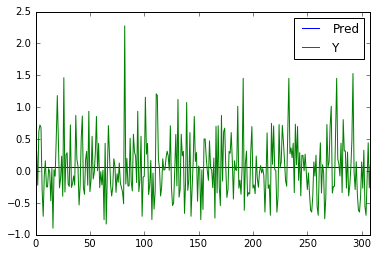

In [126]:
plt.figure()
Comp[["Pred","Y"]].plot()

## SVR Regression

In [129]:
def SVR_param(X_train,Y_train):
    
    #rough grid
    kf = KFold(n_splits=10)
    parameters = {'C':np.exp(np.arange(-5,10,1))}
    svr = SVR(kernel='linear',epsilon=0.01)
    clf = GridSearchCV(svr, parameters,cv=kf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])
    
    #fine grid
    parameters = {'C':np.exp(np.arange(best_power-0.5,best_power+0.6,0.1))}
    clf = GridSearchCV(svr, parameters,cv=kf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])

    return best_power

In [130]:
#construct model and predict
#X=X_text.as_matrix()
#Y=Y.as_matrix().reshape(Y.shape[0],)

X_train,Y_train=get_train(X,Y,1.0)
X_test=X_train
Y_test=Y_train

best_param=SVR_param(X_train,Y_train)
svr = SVR(kernel='linear',C=np.exp(best_param),epsilon=0.01)
svr.fit(X_train,Y_train)
pred=svr.predict(X_test)

In [147]:
coefs=svr.coef_
coefs=coefs.reshape(coefs.shape[1],)
print(svr.intercept_)

[-0.02960851]


In [208]:
SVR_coefs=pd.DataFrame({"Weight":coefs},index=X_text.columns)
SVR_coefs["Abs_weight"]=abs(SVR_coefs["Weight"])
SVR_coefs=SVR_coefs.sort_values(["Abs_weight"],ascending=[False])
toexport=SVR_coefs[:50]
#pd.DataFrame(toexport).to_csv("8K Data\keywords_ITEM202.csv")

In [213]:
df[df["conditionon"]!=0][["ebitda","Company Name"]]

,ebitda,Company Name
342,0.000000,GREAT PLAINS ENERGY INC
787,0.096801,AARON'S INC
880,0.000000,NORTHWESTERN CORP
1239,0.000000,REGENCY CENTERS CORP
1316,0.000000,CIENA CORP
1347,0.000000,WASHINGTON FEDERAL INC
1412,0.000000,DENBURY RESOURCES INC
1691,0.000000,GREAT PLAINS ENERGY INC
1983,0.147500,AARON'S INC
2035,0.000000,NORTHWESTERN CORP


In [143]:
Comp=pd.DataFrame({"Y":Y_test,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
Comp

,Pred,Y,Error
0,0.165739,-0.418326,0.584065
1,0.193571,0.309113,0.115541
2,-0.194457,-0.223151,0.028694
3,0.392129,0.622265,0.230135
4,0.036045,0.722002,0.685957
5,-0.023165,0.680732,0.703897
6,0.157380,-0.277138,0.434518
7,-0.099708,-0.709599,0.609891
8,-0.064380,-0.074290,0.009910
9,-0.052462,0.160224,0.212686


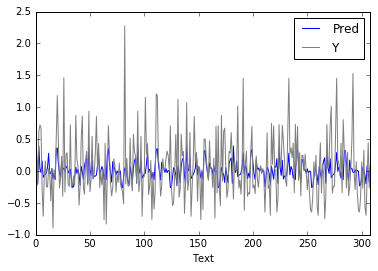

In [205]:
plt.figure()
with pd.plot_params.use('x_compat', True):
    Comp.Pred.plot(color="b",legend=True)
    Comp.Y.plot(color="grey",legend=True)
    
plt.xlabel("Text")

# Sentiment Analysis - Return - Debug

## SVM (Normalized)

## Data Preparation

In [5]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Desktop/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri")

#Setup Item Parameters 
Item="2.02"
item="ITEM"+" "+Item
itemb="202"
add0='8K Data/tfidf_ITEM'+itemb+".csv"
Ykind='Return'

#Setup Output Parameters
addX1='8K data/ITEM'+itemb+Ykind+"_X_ts.csv" 
addX2='8K data/ITEM'+itemb+Ykind+"_X_text.csv" 
addY='8K data/ITEM'+itemb+Ykind+"_Y.csv" 

In [6]:
#Import Data
df2=pd.read_csv("8K data/list_40.csv", index_col=0)
df=pd.read_csv(add0, index_col=0)
df['Date Filed']=df['Date Filed'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d').date())

In [7]:
KA=KeywordAnalyzer(df,df2)

In [8]:
df.head()

,aaron,abil,abl,absent,acceler,accept,access,accid,accompani,accord,...,work,would,wright,write,written,www,year,CIK,Company Name,Date Filed
11,0.0,0.000000,0.0,0.0,0.0,0.024765,0.0,0.0,0.029058,0.063184,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022219,1018003,INGRAM MICRO INC,2015-02-26
58,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.109055,0.091905,1025996,KILROY REALTY CORP,2015-01-29
94,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.020766,...,0.0,0.013025,0.0,0.0,0.0,0.000000,0.007303,103730,VISHAY INTERTECHNOLOGY INC,2015-02-05
130,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.046011,0.033349,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.035182,1038074,SILICON LABORATORIES INC,2015-02-04
174,0.0,0.026094,0.0,0.0,0.0,0.021211,0.0,0.0,0.000000,0.054117,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.019031,1056696,MANHATTAN ASSOCIATES INC,2015-02-03


In [9]:
df2.head()

,Ticker,Name,Price
197,KRC UN Equity,KILROY REALTY CORP,68.580
388,WR UN Equity,WESTAR ENERGY INC,57.070
215,MANH UW Equity,MANHATTAN ASSOCIATES INC,50.210
20,ARW UN Equity,ARROW ELECTRONICS INC,59.300
132,FII UN Equity,FEDERATED INVESTORS INC,25.995


In [10]:
# pull stock return as label
Y=KA.get_Y(kind=Ykind)

In [11]:
Y.head()

,Return
11,-0.022485
58,-0.027796
94,-0.025344
130,-0.021469
174,-0.000755


In [12]:
#Pull stock return time series as X
X_ts=KA.get_TS(window=1)
X_ts.head()

,Lag 0
11,0.019029
58,0.017747
94,-0.019872
130,-0.002310
174,-0.024558


In [13]:
X_ts=Normal(X_ts.as_matrix(),axis=0)

In [14]:
df_temp=df.drop(['CIK','Company Name','Date Filed'],axis=1).copy()
X_text=Normal(df_temp.as_matrix(),axis=1)

In [16]:
pd.DataFrame(X_ts).to_csv(addX1)
pd.DataFrame(X_text).to_csv(addX2)
pd.DataFrame(Y).to_csv(addY)

In [17]:
X_ts=pd.read_csv(addX1,index_col=0)
X_text=pd.read_csv(addX2,index_col=0)
Y=pd.read_csv(addY,index_col=0)

In [18]:
X_text.columns=df_temp.columns

### SVM Pipeline--Text Only - To Debug

In [134]:
def SVM_param(X_train,Y_train):

    #rough grid
    skf = StratifiedKFold(n_splits=10)
    parameters = {'C':np.exp(np.arange(-5,10,1))}
    svc = svm.SVC(kernel='linear')
    clf = GridSearchCV(svc, parameters,cv=skf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])
    
    #fine grid
    parameters = {'C':np.exp(np.arange(best_power-0.5,best_power+0.6,0.1))}
    clf = GridSearchCV(svc, parameters,cv=skf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])
    
    return(best_power)

def SVM_pipeline(X,Y, train_ratio):
    t_sample=int(np.floor(X.shape[0]*train_ratio))
    X_train=X[:t_sample,:]
    Y_train=Y[:t_sample]
    X_test=X_train
    Y_test=Y_train
    
    #rough grid
    skf = StratifiedKFold(n_splits=10)
    parameters = {'C':np.exp(np.arange(-5,10,1))}
    svc = svm.SVC(kernel='linear')
    clf = GridSearchCV(svc, parameters,cv=skf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])
    
    #fine grid
    parameters = {'C':np.exp(np.arange(best_power-0.5,best_power+0.6,0.1))}
    clf = GridSearchCV(svc, parameters,cv=skf)
    clf.fit(X_train, Y_train)
    best_power=np.log(clf.best_params_['C'])
    
    #construct model and predict
    svc = svm.SVC(kernel='linear',C=np.exp(best_power))
    svc.fit(X_train,Y_train)
    pred=svc.predict(X_test)
    c_mat=confusion_matrix(Y_test, pred)
    #auc=roc_auc_score(Y_test, pred)
    
    return pred,c_mat

In [141]:
#construct model and predict
#X=X_text.as_matrix()
#Y=np.sign(Y.as_matrix().reshape(Y.shape[0],))

X_train,Y_train=get_train(X,Y,1.0)
X_test=X_train
Y_test=Y_train

best_power=SVM_param(X_train,Y_train)

svc = svm.SVC(kernel='linear',C=np.exp(best_power))
svc.fit(X_train,Y_train)
pred=svc.predict(X_test)
c_mat=confusion_matrix(Y_test, pred)

ValueError: All the n_groups for individual classes are less than n_splits=10.

In [97]:
c_mat

array([[106,   4,  25],
       [ 11,  24,   9],
       [ 31,   7,  92]])

In [99]:
t_sample=216
Comp=pd.DataFrame({"Y":Y_test,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
print(Comp[Comp["Error"]==0].shape[0])
print(Comp[Comp["Error"]==1].shape[0])
print(Comp[Comp["Error"]==2].shape[0])

222
31
56


In [100]:
Comp

,Pred,Y,Error
0,-1.0,-1.0,0.0
1,-1.0,-1.0,0.0
2,-1.0,-1.0,0.0
3,-1.0,-1.0,0.0
4,1.0,-1.0,2.0
5,0.0,1.0,1.0
6,1.0,1.0,0.0
7,1.0,1.0,0.0
8,1.0,1.0,0.0
9,-1.0,-1.0,0.0


### TS+Text

In [101]:
X=np.concatenate([X_ts.as_matrix(),X_text.as_matrix()],axis=1)
Y_new=np.sign(Y.as_matrix()).reshape(Y.shape[0],)

In [102]:
pred, c_mat=SVM_pipeline(X,Y_new, 1.0)

In [103]:
c_mat

array([[110,   3,  22],
       [ 12,  19,  13],
       [ 32,   6,  92]])

In [104]:
t_sample=216
Comp=pd.DataFrame({"Y":Y_new,
                  "Pred":pred})
Comp["Error"]=abs(Comp["Y"]-Comp["Pred"])
print(Comp[Comp["Error"]==0].shape[0])
print(Comp[Comp["Error"]==1].shape[0])
print(Comp[Comp["Error"]==2].shape[0])

221
34
54


In [105]:
Comp

,Pred,Y,Error
0,-1.0,-1.0,0.0
1,-1.0,-1.0,0.0
2,-1.0,-1.0,0.0
3,-1.0,-1.0,0.0
4,1.0,-1.0,2.0
5,0.0,1.0,1.0
6,1.0,1.0,0.0
7,1.0,1.0,0.0
8,1.0,1.0,0.0
9,-1.0,-1.0,0.0


## SVM (Non-Normalized)

In [196]:
X1, X2,Y= KA.prep_Classifier(normalize=False)

In [197]:
pd.DataFrame(X1).to_csv('X1.csv')
pd.DataFrame(X2).to_csv('X2.csv')
pd.DataFrame(Y).to_csv('Y.csv')

In [198]:
# Time series only
pred, c_mat, auc=SVM_pipeline(X1,Y, 0.7)

In [199]:
c_mat

array([[170,  21],
       [ 83,  20]])

In [200]:
auc

0.54211355665124783

In [201]:
# Text only
pred, c_mat, auc=SVM_pipeline(X2,Y, 0.7)

In [202]:
c_mat

array([[180,  11],
       [ 89,  14]])

In [203]:
auc

0.5391653535302191

In [204]:
#Combined
pred, c_mat, auc=SVM_pipeline(np.concatenate([X1,X2],axis=1),Y, 0.7)

In [205]:
c_mat

array([[172,  19],
       [ 83,  20]])

In [206]:
auc

0.54734915874548873